# 分類アルゴリズム選択　2

## 決定木型アルゴリズム

モデルの構造は、ノードである項目と閾値から2つに分岐し、\
繰り返して分類していく特徴を持つモデル

## 実行のための前処理

In [ ]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [ ]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# 乱数の種
random_seed = 123

# 0. サンプルコーディングで用いるデータ

In [ ]:
# サンプルデータの生成

# ライブラリインポート
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification

# 線形分離型
X1, y1 = make_classification(n_features=2, n_redundant=0, 
    n_informative=2, random_state=random_seed, 
    n_clusters_per_class=1, n_samples=200, n_classes=2)

# 三日月型 (線形分離不可)
X2, y2 = make_moons(noise = 0.05, random_state=random_seed, 
    n_samples=200)

# 円形 (線形分離不可)
X3, y3 = make_circles(noise = 0.02, random_state=random_seed, 
    n_samples=200)

# 3種類のデータをDataListに保存
DataList = [(X1, y1), (X2, y2), (X3, y3)]

# N: データの種類数
N = len(DataList)

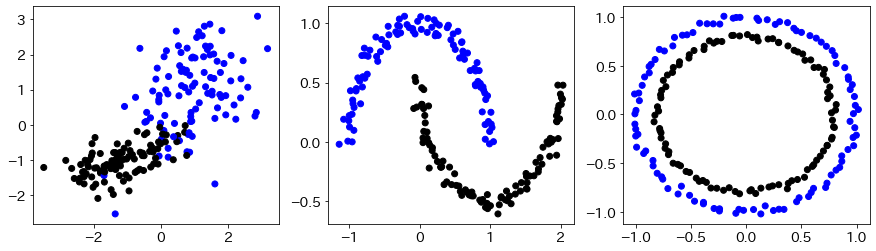

In [ ]:
# 散布図表示
plt.figure(figsize=(15,4))

# カラーマップ定義
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#0000FF', '#000000'])

for i, data in enumerate(DataList):
    X, y = data
    ax = plt.subplot(1, N, i+1)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap)
    
plt.show()

## 学習結果を表示する関数

In [ ]:
from sklearn.model_selection import train_test_split

# 決定境界の表示関数
def plot_boundary(ax, x, y, algorithm):
    x_train, x_test, y_train, y_test = train_test_split(x, y,
            test_size=0.5, random_state=random_seed)
    # カラーマップ定義
    from matplotlib.colors import ListedColormap
    cmap1 = plt.cm.bwr
    cmap2 = ListedColormap(['#0000FF', '#000000'])

    h = 0.005
    # アルゴリズムでの学習
    algorithm.fit(x_train, y_train)
    # 学習結果の取得
    score_test = algorithm.score(x_test, y_test)
    score_train = algorithm.score(x_train, y_train)

    # モデルの確信度を表示するための処理
    f1_min = x[:, 0].min() - 0.5
    f1_max = x[:, 0].max() + 0.5
    f2_min = x[:, 1].min() - 0.5
    f2_max = x[:, 1].max() + 0.5
    f1, f2 = np.meshgrid(np.arange(f1_min, f1_max, h), 
                         np.arange(f2_min, f2_max, h))
    # アルゴリズムによって処理を分ける
    # 分類の確信度はdecision_functionとpredict_proba選べるがpredict_probaしかないアルゴリズムがある
    if hasattr(algorithm, "decision_function"):
        # decision_functionはレンジなしの信頼度を表す。
        Z = algorithm.decision_function(np.c_[f1.ravel(), f2.ravel()])
        Z = Z.reshape(f1.shape)
        ax.contour(f1, f2, Z, levels=[0], linewidth=2)
    else:
        # predict_probaはそのクラスに分類される確率を表す。
        Z = algorithm.predict_proba(np.c_[f1.ravel(), f2.ravel()])[:, 1]
        Z = Z.reshape(f1.shape)

    # エリアを表示する
    ax.contourf(f1, f2, Z, cmap=cmap1, alpha=0.3)
    
    # 散布図の表示
    ax.scatter(x_test[:,0], x_test[:,1], c=y_test, cmap=cmap2)
    ax.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=cmap2, marker='x')
    # 学習結果の表示
    text = f'検証:{score_test:.2f}  訓練: {score_train:.2f}'
    ax.text(f1.max() - 0.3, f2.min() + 0.3, text, horizontalalignment='right',
    fontsize=18) 
    

In [ ]:
# 散布図と決定境界の表示関数

def plot_boundaries(algorithm, DataList):
    plt.figure(figsize=(15,4))
    for i, data in enumerate(DataList):
        X, y = data
        ax = plt.subplot(1, N, i+1)
        plot_boundary(ax, X, y, algorithm)
    plt.show()

#1. 決定木

##  ツリー構造、2分木を使って分類を行うモデル

### 概要
決定木の層の深さを決めることで、精度が上がったり下がったりする\
過学習についても見ていきます。


 ##  決定木のイメージを示します。

In [1]:
# 追加ライブラリのimport
import seaborn as sns

# サンプルデータの読み込み
df_iris = sns.load_dataset("iris")
# 2種類の花に絞り込み
df2 = df_iris[50:150]

# データ分離
X = df2.drop('species', axis=1)
y = df2['species']

In [2]:
# 学習
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(random_state=random_seed)
algorithm.fit(X, y)

# 決定木のツリー表示
from sklearn import tree
with open('iris-dtree.dot', mode='w') as f:
    tree.export_graphviz( algorithm, out_file=f,
        feature_names=X.columns, filled=True, rounded=True,  
        special_characters=True, impurity=False, proportion=False
    ) 
import pydotplus
from IPython.display import Image
graph = pydotplus.graphviz.graph_from_dot_file('iris-dtree.dot')
graph.write_png('iris-dtree.png')
Image(graph.create_png())

NameError: ignored

## サンプルデータで分類した結果を示します

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


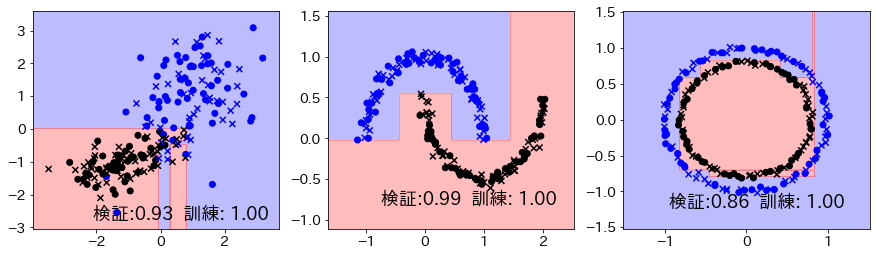

In [ ]:
# 決定木の散布図・分類結果表示

# アルゴリズムの選定
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(random_state=random_seed)

# アルゴリズムの持つパラメータの表示 
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

ハイパーパラメータを変更して、過学習の状態を同じデータで再現

max_depthというパラメータを変更\
決定木のツリーの層の深さを指定　デフォルトはNone(上限なし)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


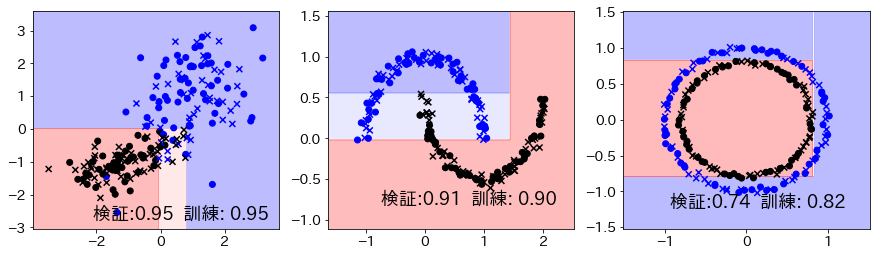

In [ ]:
# 決定木の散布図・分類結果表示(max_depth=3の場合)

# アルゴリズムの選定
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(max_depth=3, 
    random_state=random_seed)

# アルゴリズムの持つパラメータの表示 
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

# 2. ランダムフォレスト

## 簡易分類器による多数決で分類する

### 概要
データを複数に分割して分類器を作り、\
分類器の結果を集計して多数決により分類を決定する

分類器で扱うデータは重複を許す方法をブートストラップ法という




## ランダムフォレストの処理のイメージを表示します。

スライドへ

## サンプルデータで分類した結果を示します

In [ ]:
# ランダムフォレストの散布図・分類結果表示

# アルゴリズムの選定
from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier(random_state=random_seed)

# アルゴリズムの持つパラメータの表示 
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

# 3. XGBoost

## 「アンサンブル」という複数の決定木を使って分類手法の中で、「バギング」と「ブースティング」を組み合わせたモデル

### 概要

アンサンブル：推定値と実測値の差を表しますバイアスと推定値のばらつきを\
表すバリアンスを上手く調整する手法群です。

バギング：弱分類器を複数並べてその結果の多数決で分類する

ブースティング：分類器の分類結果と正解データから新しい分類器を作成する工程を繰り返し、最終的な分類ヲする

## ブースティングの処理のイメージを表示します

スライドへ

## サンプルデータで分類した結果を示します

In [ ]:
# XGBoostの散布図・分類結果表示

# アルゴリズムの選定
import xgboost
algorithm = xgboost.XGBClassifier(random_state=random_seed)

# アルゴリズムの持つパラメータの表示 
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

## 参考
バージョン確認用

In [ ]:
import sklearn
print(sklearn.__version__)